# Отток клиентов

В данном проекте я исследую модель предсказания оттока клиентов. 
Вначале, я загружая данные и исследую их. 
Далее я оцениваю тестовую модель, не принимая во внимание баланс классов.
На следующем этапе я применяю несоколько методов борьбы с дисбалансом классов и оцениваю качество предсказаний моделей в данном случае.
В конце проекта выбранную модель я оцениваю на тестовой выборке.

## Подготовка данных

In [213]:
# загружаю библиотеки
import warnings
warnings.filterwarnings('ignore') # отключим предупреждения, чтобы не отвлекали
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import bernoulli
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTE, ADASYN

### Первое знакомство с данными

In [214]:
# загружаю данные
data=pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [215]:
# смотрю на данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видно, что есть некоторые переменные, которые нам не пригодятся для прогнозирования оттока: RowNumber, CustomerID, Surname. Удалю их из данных.

In [216]:
# удаляю переменные
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


В названии колокок использован camelcase, для удобства поменяю на capitalize.

In [217]:
# меняю названия колонок
data.columns = data.columns.str.capitalize()
data.columns

Index(['Creditscore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'Numofproducts', 'Hascrcard', 'Isactivemember', 'Estimatedsalary',
       'Exited'],
      dtype='object')

В данные есть категориальные перемменные, которые нужно будет перевести в бинарные. Так же в переменной Tenure есть пропуски, которые нужно заполнить. Последним шагом обработки данных будет их стандартизация. Но для того, чтобы избежать data leakage всё эти манипуляции с данными я буду делать после разбиения данных на выборки. 

### Разбиение на подвыборки

Я разделю данные на тренировочную, валидационную и тестовую выборки в пропорции 3:1:1. 

In [218]:
# Разделяю на выборки
features = data.drop('Exited', axis=1)
target = data['Exited']
features_train, features_valid, target_train, target_valid = (
    train_test_split(features, target, test_size=0.4, random_state=42)
)
features_valid, features_test, target_valid, target_test = (
    train_test_split(features_valid, target_valid, test_size=0.5, random_state=42)
)
display(features_train.shape[0])
display(features_valid.shape[0])
features_test.shape[0]

6000

2000

2000

Я правильно разделила на выборки. Теперь перейду к обработке данных в подвыборках.

### Обработка данных

#### Обработка численных и категориальных признаков

Заменим две категориальные переменные на дамми-переменные.

Добавлю в фичи квадрат баланса.

In [225]:
# Добавляю новую переменную
data['Balance_sq'] = data['Balance']**2

In [226]:
# Разделим данные на численные и категориальные
categorical = ['Geography', 'Gender']
numerical = data.drop(['Geography', 'Gender', 'Exited', 'Hascrcard', 'Isactivemember'], axis=1).columns

In [228]:
# Задаю трансформеры
numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=5, weights="uniform")),('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [229]:
# Задаю препроцессор
preprocessor = (
    make_column_transformer((numeric_transformer, numerical),(categorical_transformer, categorical), 
                            remainder = 'passthrough',
                            verbose_feature_names_out=False))

#### Изучение данных

Посмотрим на матрицу корреляций

In [230]:
# Посмотрим на таблицу корреляций
data[numerical].corr().style.background_gradient('coolwarm')

,Creditscore,Age,Tenure,Balance,Numofproducts,Estimatedsalary,Balance_sq
Creditscore,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.001384,0.004604
Age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.007201,0.020248
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.010520,-0.006856
Balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,0.012797,0.956978
Numofproducts,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.014204,-0.256097
Estimatedsalary,-0.001384,-0.007201,0.010520,0.012797,0.014204,1.000000,0.010742
Balance_sq,0.004604,0.020248,-0.006856,0.956978,-0.256097,0.010742,1.000000


Сильные корреляций между независимыми переменными нет кроме квадрата баланса, который скоррелирован с балансом.

В данном разделе я загрузила данные и разбила их на тренировочную, валидационную и тестовую выборки. 
Я подготовила трансформеры, которые будут создавать бинарные переменные для категориальных данных, нормализовывать численные переменные и заполнять пропуски. 
Я посмотрела на зависимость между разными переменными и увидела, что баланс на счету сконцентрирован вокруг какого-то значения. Чтобы модели могли отобразить эту зависимость я ввела в переменные квадрат баланса. 

## Исследование задачи

### Баланс классов

Посмотрим, как много у нас в данных людей, которые уходят и клиентов, которые остаются.

In [231]:
# Подсчёт значений
data['Exited'].value_counts(True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Выборка очень несбалансирова - тех, кто уходит почти что в 4 раза меньше, чем тех, кто остался. Эту проблему я буду решать методами балансировки классов в следующем разделе.

### Первоначальный выбор модели

#### Дерево решений

In [232]:
# Инициализируем дерево решений
model_tree = DecisionTreeClassifier(random_state=42)

In [233]:
# Создаём пайплайн
pipeline_tree = make_pipeline(preprocessor, model_tree)

param_grid_tree = {
    'decisiontreeclassifier__max_depth': range(1,30)
}

gs_tree = GridSearchCV(
    pipeline_tree, 
    param_grid=param_grid_tree, 
    scoring='f1'
)
gs_tree.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Geography',
                                                                          'Gender'])],
                                                          verbose_feature_names_out=False)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'decisiontreeclassifier__max_depth': range(1, 30)},
             scoring='f1')

Посмотрим на лучшую метрику и параметры.

In [234]:
display(gs_tree.best_score_)
gs_tree.best_params_

0.5493555668028035

{'decisiontreeclassifier__max_depth': 9}

#### Случайный лес

In [235]:
# Задаю пайплайн
model_forest = RandomForestClassifier(random_state=42)

pipline_forest = make_pipeline(preprocessor, model_forest)

param_grid_forest = {
    'randomforestclassifier__n_estimators': range(10, 110, 30),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}


gs_forest = RandomizedSearchCV(
    pipline_forest, 
    param_distributions=param_grid_forest, 
    scoring='f1', 
    random_state=42
)

In [236]:
# Оцениваю модель
gs_forest.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('...
                                                                verbose_feature_names_out=False)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'randomforestclassifier__max_depth': range(2, 15),
                                        'randomforestclassifier__min_samples_leaf': (1,
                                                                                     2,
                                                                                     3,
                                                                                     4),
                                        'randomforestclassifier__min_samples_split': (2,
                                                                                      3,
                                                                                      4),
                                        'randomforestclassifier__n_estimators': range(10, 110, 30)},
                   random_state=42, scoring='f1')

In [237]:
# Результаты кросс-валидации
display(gs_forest.best_score_)
gs_forest.best_params_

0.5668391971603426

{'randomforestclassifier__n_estimators': 40,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__max_depth': 12}

Метрика f1 при кроссвалидации немного улучшилась по сравнению с деревом решений.

Наилучшей моделью случайного леса оказался лес глубины 12 из 40 деревьев. Он показал при кросс-валидации f1=0.56. Это лучше, чем дерево решений.

#### Логистическая регрессия

Теперь посмотрим модель логистической регрессии.

In [238]:
# Создаём пайплайн
model_logit = LogisticRegression(random_state=42)
pipeline_logit = make_pipeline(preprocessor, model_logit)

param_grid_logit = {
    'logisticregression__penalty' : ['l1','l2'], 
    'logisticregression__C'       : np.logspace(-3,3,7),
    'logisticregression__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

gs_logit = RandomizedSearchCV(
    pipeline_logit, 
    param_distributions=param_grid_logit, 
    scoring='f1',
    random_state=42
)

gs_logit.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('...
                                                                               ['Geography',
                                                                                'Gender'])],
                                                                verbose_feature_names_out=False)),
                                             ('logisticregression',
                                              LogisticRegression(random_state=42))]),
                   param_distributions={'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'logisticregression__penalty': ['l1',
                                                                        'l2'],
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'liblinear']},
                   random_state=42, scoring='f1')

In [239]:
# Смотрю на результаты
display(gs_logit.best_score_)
gs_logit.best_params_

0.3064510728040521

{'logisticregression__solver': 'liblinear',
 'logisticregression__penalty': 'l1',
 'logisticregression__C': 10.0}

В логистической регрессии метрика при кросс-валидации значительно уступает и дереву решений и случайному лесу. 

Сравним результатыт для трёх классов моделей.

In [240]:
# Таблица
result = pd.DataFrame(
    [gs_tree.best_score_, gs_forest.best_score_, gs_logit.best_score_], 
    index=['Decision Tree', 'Random Forest', 'Logit'], 
    columns=['f1']
)
result

,f1
Decision Tree,0.549356
Random Forest,0.566839
Logit,0.306451


Если не обрабатывать дисбаланс классов, то лучший результат на кросс-валидации показывает модель Случайного леса.

Посмотрим roc кривую для этих трёх классификаторов.

In [241]:
# roc-curve
fpr_dt, tpr_dt, threshold_dt = (
    roc_curve(pd.concat([target_train]+[target_valid]),
              gs_tree.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]))
fpr_rf, tpr_rf, threshold_rf = (
    roc_curve(pd.concat([target_train]+[target_valid]),
              gs_forest.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]))
fpr_l, tpr_l, threshold_l = (
    roc_curve(pd.concat([target_train]+[target_valid]),
              gs_logit.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]))

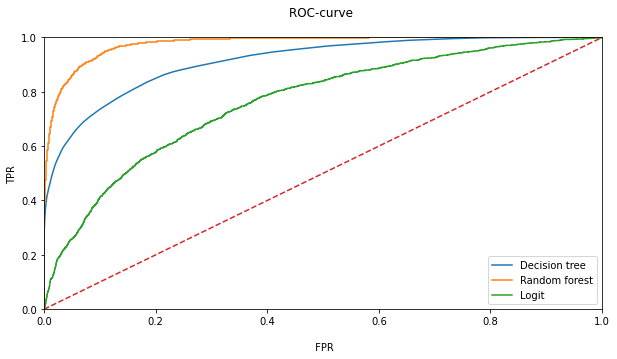

In [242]:
# график
plt.figure(figsize = (10,5))
plt.title('ROC-curve \n')
plt.xlabel('\n FPR')
plt.ylabel('TPR')
plt.plot(fpr_dt, tpr_dt, label='Decision tree');
plt.plot(fpr_rf, tpr_rf, label='Random forest')
plt.plot(fpr_l, tpr_l, label='Logit')
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle='--');
plt.xlim(0,1);
plt.ylim(0,1);
plt.legend();
plt.show();

На графике roc curve мы тоже видим, что случайный лес ближе к идеальному классификатору.

В данном разделе я изучила баланс классов и поняла, что классы очень сильно разбалансированы. В следующем разделе я буду применять методы борьбы с дисбалансом классов. 
Я сделала первичную оценку разных моделей, не учитывая дисбаланс классова. Лучше себя в плане f1-метрики на валидационной выборке показала себя модель случайного леса глубиной 11 из 70 деревьев. В следующем разделе я буду сравнивать модели для разных способов учёта дисбаланса классов.

## Борьба с дисбалансом

Продолжим оценивать модель случайного леса, но теперь будем адресовать проблему несбалансированности классов.

Для всех методов, кроме методов апсамплинга я буду использовать всю выборку из train и valid и оценивать модель с помощью кросс-валидации. Для методов апсамплинга, я буду использовать только тренировочную выборку для обучения, а валидационную для валидации.

### Взвешивание классов

#### Дерево решений

In [243]:
# Создаём пайплайн
model_tree_weight = DecisionTreeClassifier(random_state=42, class_weight='balanced')
pipeline_tree_weight = make_pipeline(preprocessor, model_tree_weight)

param_grid_tree = {
    'decisiontreeclassifier__max_depth': range(1,30)
}

gs_tree_weight = GridSearchCV(
    pipeline_tree_weight, 
    param_grid=param_grid_tree, 
    scoring='f1'
)
gs_tree_weight.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Geography',
                                                                          'Gender'])],
                                                          verbose_feature_names_out=False)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             param_grid={'decisiontreeclassifier__max_depth': range(1, 30)},
             scoring='f1')

In [244]:
# Вывод 
f1_tree_weight = gs_tree_weight.best_score_
display(f1_tree_weight)
gs_tree_weight.best_params_

0.5576845977314651

{'decisiontreeclassifier__max_depth': 6}

Метрика немного увеличилась по сравнению с оценкой на несбалансированной выборке, но не сильно.

#### Случайный лес

In [245]:
# Пайплайн
model_forest_weight = RandomForestClassifier(random_state=42, class_weight='balanced')

pipline_forest_weight = make_pipeline(preprocessor, model_forest_weight)

param_grid_forest = {
    'randomforestclassifier__n_estimators': range(10, 110, 30),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}


gs_forest_weight = RandomizedSearchCV(
    pipline_forest_weight, 
    param_distributions=param_grid_forest, 
    scoring='f1', 
    random_state=42
)

gs_forest_weight.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('...
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   param_distributions={'randomforestclassifier__max_depth': range(2, 15),
                                        'randomforestclassifier__min_samples_leaf': (1,
                                                                                     2,
                                                                                     3,
                                                                                     4),
                                        'randomforestclassifier__min_samples_split': (2,
                                                                                      3,
                                                                                      4),
                                        'randomforestclassifier__n_estimators': range(10, 110, 30)},
                   random_state=42, scoring='f1')

In [246]:
# Вывод 
f1_forest_weight = gs_forest_weight.best_score_
display(f1_forest_weight)
gs_forest_weight.best_params_

0.6161510312139223

{'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__max_depth': 11}

Метрика при кросс-валидации при разных весах классов действительно получилась выше.

#### Logistic Regression

In [247]:
# Создаём пайплайн
model_logit_weight = LogisticRegression(random_state=42)
pipeline_logit_weight = make_pipeline(preprocessor, model_logit)

param_grid_logit = {
    'logisticregression__penalty' : ['l1','l2'], 
    'logisticregression__C'       : np.logspace(-3,3,7),
    'logisticregression__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

gs_logit_weight = RandomizedSearchCV(
    pipeline_logit_weight, 
    param_distributions=param_grid_logit, 
    scoring='f1',
    random_state=42
)

gs_logit_weight.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('...
                                                                               ['Geography',
                                                                                'Gender'])],
                                                                verbose_feature_names_out=False)),
                                             ('logisticregression',
                                              LogisticRegression(random_state=42))]),
                   param_distributions={'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'logisticregression__penalty': ['l1',
                                                                        'l2'],
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'liblinear']},
                   random_state=42, scoring='f1')

In [248]:
# Смотрю на результаты
f1_logit_weight = gs_logit_weight.best_score_
display(f1_logit_weight)
gs_logit_weight.best_params_

0.3064510728040521

{'logisticregression__solver': 'liblinear',
 'logisticregression__penalty': 'l1',
 'logisticregression__C': 10.0}

Логистическая регрессия снова сильно уступает случайному лесу и дереву решений.

### StratifiedKFold

При дисбалансе классов можно использовать кросс валидацию со стратификацией. В данном подразделе я буду использовать метод StratifiedKFold.

In [249]:
# Иницирую разбивку
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#### Decision Tree

In [250]:
# Создаём пайплайн
model_tree_strat = DecisionTreeClassifier(random_state=42)
pipeline_tree_strat = make_pipeline(preprocessor, model_tree_strat)

param_grid_tree = {
    'decisiontreeclassifier__max_depth': range(1,30)
}

gs_tree_strat = GridSearchCV(
    pipeline_tree_strat, 
    param_grid=param_grid_tree, 
    scoring='f1',
    cv=skf
)
gs_tree_strat.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Geography',
                                                                          'Gender'])],
                                                          verbose_feature_names_out=False)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'decisiontreeclassifier__max_depth': range(1, 30)},
             scoring='f1')

In [251]:
# Вывод 
f1_tree_strat = gs_tree_strat.best_score_
display(f1_tree_strat)
gs_tree_strat.best_params_

0.5526761037997215

{'decisiontreeclassifier__max_depth': 7}

Метрика кросс валидации для дерева решений осталась примерно такой же.

#### Random Forest

In [252]:
# Создаём пайплайн
model_forest_strat = RandomForestClassifier(random_state=42)
pipeline_forest_strat = make_pipeline(preprocessor, model_forest_strat)

param_grid_forest = {
    'randomforestclassifier__n_estimators': range(10, 110, 30),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}


gs_forest_strat = RandomizedSearchCV(
    pipeline_forest_strat, 
    param_distributions=param_grid_forest, 
    scoring='f1', 
    random_state=42,
    cv=skf
)

gs_forest_strat.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Ba...
                                                                verbose_feature_names_out=False)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'randomforestclassifier__max_depth': range(2, 15),
                                        'randomforestclassifier__min_samples_leaf': (1,
                                                                                     2,
                                                                                     3,
                                                                                     4),
                                        'randomforestclassifier__min_samples_split': (2,
                                                                                      3,
                                                                                      4),
                                        'randomforestclassifier__n_estimators': range(10, 110, 30)},
                   random_state=42, scoring='f1')

In [253]:
# Вывод 
f1_forest_strat = gs_forest_strat.best_score_
display(f1_forest_strat)
gs_forest_strat.best_params_

0.5634389022370275

{'randomforestclassifier__n_estimators': 40,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__max_depth': 12}

Для случайного леса при валидации со стратификацией тоже метрика кросс валидации оказалась ниже.

#### Логистическая регрессия

In [254]:
# Создаём пайплайн
model_logit_strat = LogisticRegression(random_state=42)
pipeline_logit_strat = make_pipeline(preprocessor, model_logit_strat)

param_grid_logit = {
    'logisticregression__penalty' : ['l1','l2'], 
    'logisticregression__C'       : np.logspace(-3,3,7),
    'logisticregression__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

gs_logit_strat = RandomizedSearchCV(
    pipeline_logit_strat, 
    param_distributions=param_grid_logit, 
    scoring='f1',
    random_state=42,
    cv=skf
)

gs_logit_strat.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Ba...
                                                                               ['Geography',
                                                                                'Gender'])],
                                                                verbose_feature_names_out=False)),
                                             ('logisticregression',
                                              LogisticRegression(random_state=42))]),
                   param_distributions={'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'logisticregression__penalty': ['l1',
                                                                        'l2'],
                                        'logisticregression__solver': ['newton-cg',
                                                                       'lbfgs',
                                                                       'liblinear']},
                   random_state=42, scoring='f1')

In [255]:
# Смотрю на результаты
f1_logit_strat = gs_logit_strat.best_score_
display(f1_logit_strat)
gs_logit_strat.best_params_

0.30854105521260633

{'logisticregression__solver': 'liblinear',
 'logisticregression__penalty': 'l1',
 'logisticregression__C': 10.0}

### Undersampling

#### Decision Tree

In [256]:
# Understampler
undersampler = RandomUnderSampler(random_state=42)

In [257]:
# Создаём пайплайн
model_tree_u = DecisionTreeClassifier(random_state=42)
pipeline_tree_u = Pipeline_imb([('undersampler',undersampler), ('preprocessor',preprocessor), ('estimation',model_tree_u)])

param_grid_tree = {
    'estimation__max_depth': range(1,30)
}

gs_tree_u = GridSearchCV(
    pipeline_tree_u, 
    param_grid=param_grid_tree, 
    scoring='f1',
)
gs_tree_u.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

GridSearchCV(estimator=Pipeline(steps=[('undersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Geography',
                                                                          'Gender'])],
                                                          verbose_feature_names_out=False)),
                                       ('estimation',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'estimation__max_depth': range(1, 30)}, scoring='f1')

In [258]:
# Вывод 
f1_tree_u = gs_tree_u.best_score_
display(f1_tree_u)
gs_tree_u.best_params_

0.5516300617995797

{'estimation__max_depth': 5}

#### Random forest

In [259]:
# Создаём пайплайн
model_forest_u = RandomForestClassifier(random_state=42)
pipeline_forest_u = Pipeline_imb([('undersampler',undersampler), ('preprocessor',preprocessor), ('estimation',model_forest_u)])

param_grid_forest = {
    'estimation__n_estimators': range(10, 110, 30),
    'estimation__max_depth': range(2, 15),
    'estimation__min_samples_split': (2, 3, 4),
    'estimation__min_samples_leaf': (1, 2, 3, 4)
}


gs_forest_u = RandomizedSearchCV(
    pipeline_forest_u, 
    param_distributions=param_grid_forest, 
    scoring='f1', 
    random_state=42
)

gs_forest_u.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

RandomizedSearchCV(estimator=Pipeline(steps=[('undersampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      d...
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['Geography',
                                                                                'Gender'])],
                                                                verbose_feature_names_out=False)),
                                             ('estimation',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'estimation__max_depth': range(2, 15),
                                        'estimation__min_samples_leaf': (1, 2,
                                                                         3, 4),
                                        'estimation__min_samples_split': (2, 3,
                                                                          4),
                                        'estimation__n_estimators': range(10, 110, 30)},
                   random_state=42, scoring='f1')

In [260]:
# Вывод 
f1_forest_u = gs_forest_u.best_score_
display(gs_forest_u.best_score_)
gs_forest_u.best_params_

0.5880377852393092

{'estimation__n_estimators': 100,
 'estimation__min_samples_split': 4,
 'estimation__min_samples_leaf': 2,
 'estimation__max_depth': 6}

#### Logistic Regression

In [261]:
# Создаём пайплайн
model_logit_u = LogisticRegression(random_state=42)
pipeline_logit_u = Pipeline_imb([('undersampler',undersampler), ('preprocessor',preprocessor), ('estimation',model_logit_u)])

param_grid_logit = {
    'estimation__penalty' : ['l1','l2'], 
    'estimation__C'       : np.logspace(-3,3,7),
    'estimation__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

gs_logit_u = RandomizedSearchCV(
    pipeline_logit_u, 
    param_distributions=param_grid_logit, 
    scoring='f1',
    random_state=42,
)

gs_logit_u.fit(pd.concat([features_train]+[features_valid]), pd.concat([target_train]+[target_valid]))

RandomizedSearchCV(estimator=Pipeline(steps=[('undersampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      d...
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['Geography',
                                                                                'Gender'])],
                                                                verbose_feature_names_out=False)),
                                             ('estimation',
                                              LogisticRegression(random_state=42))]),
                   param_distributions={'estimation__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'estimation__penalty': ['l1', 'l2'],
                                        'estimation__solver': ['newton-cg',
                                                               'lbfgs',
                                                               'liblinear']},
                   random_state=42, scoring='f1')

In [262]:
# Смотрю на результаты
f1_logit_u = gs_logit_u.best_score_
display(f1_logit_u)
gs_logit_u.best_params_

0.4901900023706426

{'estimation__solver': 'liblinear',
 'estimation__penalty': 'l1',
 'estimation__C': 0.01}

### Upsampling

#### SMOTE

In [284]:
oversample = SMOTE(random_state=42)

##### Decision Tree

In [285]:
# Создаём пайплайн
model_tree_smote = DecisionTreeClassifier(random_state=42)
pipeline_tree_smote = Pipeline_imb([('preprocessor',preprocessor),('oversample',oversample), ('estimation',model_tree_smote)])

param_grid_tree = {
    'estimation__max_depth': range(1,30)
}

gs_tree_smote = GridSearchCV(
    pipeline_tree_smote, 
    param_grid=param_grid_tree, 
    scoring='f1',
)
gs_tree_smote.fit(features_train,target_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Geography',
                                                                          'Gender'])],
                                                          verbose_feature_names_out=False)),
                                       ('oversample', SMOTE(random_state=42)),
                                       ('estimation',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'estimation__max_depth': range(1, 30)}, scoring='f1')

In [286]:
predict_valid_smote = gs_tree_smote.predict(features_valid)
f1_tree_smote = f1_score(target_valid, predict_valid_smote)
f1_tree_smote

0.5231719876416067

##### Random Forest

In [287]:
# Создаём пайплайн
model_forest_smote = RandomForestClassifier(random_state=42)
pipeline_forest_smote = Pipeline_imb([('preprocessor',preprocessor),('oversample',oversample), ('estimation',model_forest_smote)])

param_grid_forest = {
    'estimation__n_estimators': range(10, 110, 30),
    'estimation__max_depth': range(2, 15),
    'estimation__min_samples_split': (2, 3, 4),
    'estimation__min_samples_leaf': (1, 2, 3, 4)
}


gs_forest_smote = RandomizedSearchCV(
    pipeline_forest_smote, 
    param_distributions=param_grid_forest, 
    scoring='f1', 
    random_state=42
)

gs_forest_smote.fit(features_train,target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('oneho...
                                                                                'Gender'])],
                                                                verbose_feature_names_out=False)),
                                             ('oversample',
                                              SMOTE(random_state=42)),
                                             ('estimation',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'estimation__max_depth': range(2, 15),
                                        'estimation__min_samples_leaf': (1, 2,
                                                                         3, 4),
                                        'estimation__min_samples_split': (2, 3,
                                                                          4),
                                        'estimation__n_estimators': range(10, 110, 30)},
                   random_state=42, scoring='f1')

In [288]:
# Проверяю на валидационной выборке
predict_valid_smote = gs_forest_smote.predict(features_valid)
f1_forest_smote = f1_score(target_valid, predict_valid_smote)
f1_forest_smote

0.5775

##### Logistic Regression

In [289]:
# Создаём пайплайн
model_logit_smote = LogisticRegression(random_state=42)
pipeline_logit_smote = Pipeline_imb([('preprocessor',preprocessor),('oversample',oversample), ('estimation',model_logit_smote)])

param_grid_logit = {
    'estimation__penalty' : ['l1','l2'], 
    'estimation__C'       : np.logspace(-3,3,7),
    'estimation__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

gs_logit_smote = RandomizedSearchCV(
    pipeline_logit_smote, 
    param_distributions=param_grid_logit, 
    scoring='f1',
    random_state=42,
)

gs_logit_smote.fit(features_train,target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('oneho...
                                                                                'Gender'])],
                                                                verbose_feature_names_out=False)),
                                             ('oversample',
                                              SMOTE(random_state=42)),
                                             ('estimation',
                                              LogisticRegression(random_state=42))]),
                   param_distributions={'estimation__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'estimation__penalty': ['l1', 'l2'],
                                        'estimation__solver': ['newton-cg',
                                                               'lbfgs',
                                                               'liblinear']},
                   random_state=42, scoring='f1')

In [290]:
# Проверяю на валидационной выборке
predict_valid_smote = gs_logit_smote.predict(features_valid)
f1_logit_smote = f1_score(target_valid, predict_valid_smote)
f1_logit_smote

0.453551912568306

#### ADASYN

In [291]:
# Инициализирую алгоритм для oversample
oversample = ADASYN(random_state=42)

##### Decision Tree

In [292]:
# Создаём пайплайн
model_tree_adasyn = DecisionTreeClassifier(random_state=42)
pipeline_tree_adasyn = Pipeline_imb([('preprocessor',preprocessor),('oversample',oversample), ('estimation',model_tree_smote)])

param_grid_tree = {
    'estimation__max_depth': range(1,30)
}

gs_tree_adasyn = GridSearchCV(
    pipeline_tree_adasyn, 
    param_grid=param_grid_tree, 
    scoring='f1',
)
gs_tree_adasyn.fit(features_train,target_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Geography',
                                                                          'Gender'])],
                                                          verbose_feature_names_out=False)),
                                       ('oversample', ADASYN(random_state=42)),
                                       ('estimation',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'estimation__max_depth': range(1, 30)}, scoring='f1')

In [293]:
predict_valid_adasyn = gs_tree_adasyn.predict(features_valid)
f1_tree_adasyn = f1_score(target_valid, predict_valid_smote)
f1_tree_adasyn

0.453551912568306

##### Random Forest

In [294]:
# Создаём пайплайн
model_forest_adasyn = RandomForestClassifier(random_state=42)
pipeline_forest_adasyn = Pipeline_imb([('preprocessor',preprocessor),('oversample',oversample), ('estimation',model_forest_smote)])

param_grid_forest = {
    'estimation__n_estimators': range(10, 110, 30),
    'estimation__max_depth': range(2, 15),
    'estimation__min_samples_split': (2, 3, 4),
    'estimation__min_samples_leaf': (1, 2, 3, 4)
}


gs_forest_adasyn = RandomizedSearchCV(
    pipeline_forest_adasyn, 
    param_distributions=param_grid_forest, 
    scoring='f1', 
    random_state=42
)

gs_forest_adasyn.fit(features_train,target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('oneho...
                                                                                'Gender'])],
                                                                verbose_feature_names_out=False)),
                                             ('oversample',
                                              ADASYN(random_state=42)),
                                             ('estimation',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'estimation__max_depth': range(2, 15),
                                        'estimation__min_samples_leaf': (1, 2,
                                                                         3, 4),
                                        'estimation__min_samples_split': (2, 3,
                                                                          4),
                                        'estimation__n_estimators': range(10, 110, 30)},
                   random_state=42, scoring='f1')

In [295]:
# Проверяю на валидационной выборке
predict_valid_smote = gs_forest_adasyn.predict(features_valid)
f1_forest_adasyn = f1_score(target_valid, predict_valid_smote)
f1_forest_adasyn

0.5670225385527876

##### Logistic Regression

In [296]:
# Создаём пайплайн
model_logit_adasyn = LogisticRegression(random_state=42)
pipeline_logit_adasyn = Pipeline_imb([('preprocessor',preprocessor),('oversample',oversample), ('estimation',model_logit_smote)])

param_grid_logit = {
    'estimation__penalty' : ['l1','l2'], 
    'estimation__C'       : np.logspace(-3,3,7),
    'estimation__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

gs_logit_adasyn = RandomizedSearchCV(
    pipeline_logit_adasyn, 
    param_distributions=param_grid_logit, 
    scoring='f1',
    random_state=42,
)

gs_logit_adasyn.fit(features_train,target_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['Creditscore', 'Age', 'Tenure', 'Balance', 'Numofproducts',
       'Estimatedsalary', 'Balance_sq'],
      dtype='object')),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('oneho...
                                                                                'Gender'])],
                                                                verbose_feature_names_out=False)),
                                             ('oversample',
                                              ADASYN(random_state=42)),
                                             ('estimation',
                                              LogisticRegression(random_state=42))]),
                   param_distributions={'estimation__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'estimation__penalty': ['l1', 'l2'],
                                        'estimation__solver': ['newton-cg',
                                                               'lbfgs',
                                                               'liblinear']},
                   random_state=42, scoring='f1')

In [297]:
# Проверяю на валидационной выборке
predict_valid_adasyn = gs_logit_adasyn.predict(features_valid)
f1_logit_adasyn = f1_score(target_valid, predict_valid_smote)
f1_logit_adasyn

0.5670225385527876

In [298]:
# Оценим результаты
iterables = [["weighted", "stratified", "undersample", "smote", "adasyn"], ["tree", "forest", "logit"]]
index = pd.MultiIndex.from_product(iterables, names=["method", "model"])
result = (
    pd.DataFrame(
    [f1_tree_weight, f1_forest_weight, f1_logit_weight, 
     f1_tree_strat, f1_forest_strat, f1_logit_strat,
    f1_tree_u, f1_forest_u, f1_logit_u,
    f1_tree_smote, f1_forest_smote, f1_logit_smote,
    f1_tree_adasyn, f1_forest_adasyn, f1_logit_adasyn], 
    index=index, 
    columns=['f1']
)).style.background_gradient('coolwarm')
result

Лучшей моделью оказалась модель случайного леса со взвешиванными классами. На втором и третьем месте с довольно большим отстованием случайные лес,на данных после андерсамлинга и случайные лес, оптимизированный на данных оверсамлинга методом smote. Сравним roc кривые для этих трёх моделей.

In [299]:
# roc-curve
fpr_w, tpr_w, threshold_w = (
    roc_curve(pd.concat([target_train]+[target_valid]),
              gs_forest_weight.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]))
fpr_u, tpr_u, threshold_u = (
    roc_curve(pd.concat([target_train]+[target_valid]),
              gs_forest_u.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]))
fpr_s, tpr_s, threshold_s = (
    roc_curve(pd.concat([target_train]+[target_valid]),
              gs_forest_smote.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]))

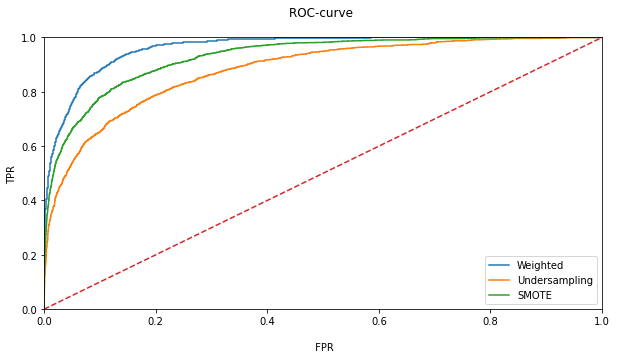

In [300]:
# график
plt.figure(figsize = (10,5))
plt.title('ROC-curve \n')
plt.xlabel('\n FPR')
plt.ylabel('TPR')
plt.plot(fpr_w, tpr_w, label='Weighted');
plt.plot(fpr_u, tpr_u, label='Undersampling')
plt.plot(fpr_s, tpr_s, label='SMOTE')
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle='--');
plt.xlim(0,1);
plt.ylim(0,1);
plt.legend();
plt.show();

На графике тоже видим, что из трёх моделей, модель случайного леса с балансирующими весами классов ближе к идеальному классификатору.

In [301]:
# auc score
auc_w = (
    roc_auc_score(pd.concat([target_train]+[target_valid]),
                  gs_forest_weight.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]))
auc_u = (
    roc_auc_score(pd.concat([target_train]+[target_valid]),
                  gs_forest_u.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]))
auc_s = (
    roc_auc_score(pd.concat([target_train]+[target_valid]),
                  gs_forest_smote.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]))
display(auc_w)
display(auc_u)
auc_s

0.9621777319254072

0.8800436188032745

0.9277618809698808

Как было видно и из графика, площадь под кривой у модели weighted выше, чем у других. Я останавлюсь на ней.

In [302]:
# Лучшая модель
best_model = gs_forest_weight.best_estimator_

### Подбор порога классификации

In [303]:
# Перебор порогов
f1_threshold = 0
best_threshold = 0.5
f1_list=[]
t_list=[]
for t in np.arange(0.1, 0.9, 0.01):
    predict_valid = best_model.predict_proba(pd.concat([features_train]+[features_valid]))[:,1]>t
    f1 = f1_score(pd.concat([target_train]+[target_valid]), predict_valid)
    f1_list.append(f1)
    t_list.append(t)
    if f1>f1_threshold:
        f1_threshold = f1
        best_threshold = t
display(f1_threshold)
best_threshold

0.7890952666267225

0.5299999999999998

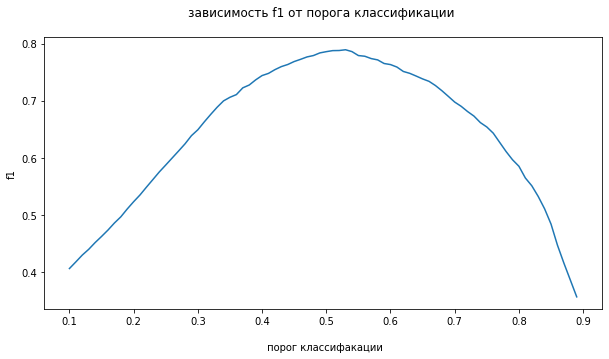

In [304]:
# график
plt.figure(figsize = (10,5))
plt.title('зависимость f1 от порога классификации \n')
plt.xlabel('\n порог классифакации')
plt.ylabel('f1')
plt.plot(t_list, f1_list);

Оптимальный порог классификации немного поменялся и теперь 0.52

В данном разделе я рассмотрела 4 варианта работы с несбалансированными классами для всех трёх видов классификаторов. Я рассмотрела модель с разными весами классов, использовала стратификацию, использовала даунсамплинг и два вида апсамплинг. Лучше всего с точки зрения f1 метрики показал себя случайный лес, полученный с помощью весов классов с подобранными гиперпараметрами. Я так же рассмотрела разные пороги классификации и наибольший f1-score получислся при пороге в 0.52 Я нарисовала графики roc кривых для трёх лучших моделей и посчитала auc метрику для них. Моедль, полученная с помощью сбалансированных весов классов была ближе к оптимальному классификатору, чем следующие по качеству модель. 

## Тестирование модели

Теперь я протестирую выбранную модель на тестовой выборке и проверю на адекватность.

### Тестовая выборка

In [307]:
# Считаю f1 на тестовой выборке
predictions_test = best_model.predict_proba(features_test)[:,1]>best_threshold
f1_test = f1_score(target_test, predictions_test)
f1_test

0.6490384615384616

На тестовой модели получилась метрика f1 даже немного выше, чем на кросс валидации на тренировочной выборке. 

In [308]:
# roc 
fpr_test, tpr_test, threshold_test = (
    roc_curve(target_test,best_model.predict_proba(features_test)[:,1]))

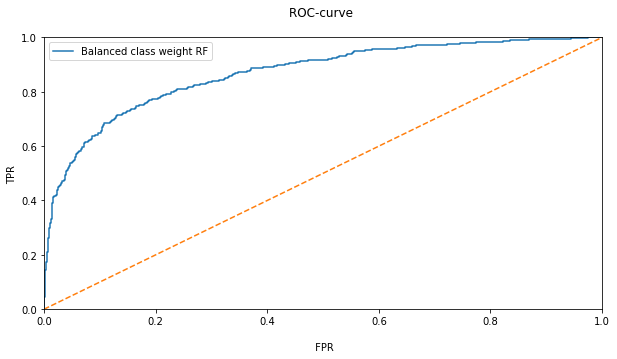

In [309]:
# график
plt.figure(figsize = (10,5))
plt.title('ROC-curve \n')
plt.xlabel('\n FPR')
plt.ylabel('TPR')
plt.plot(fpr_test, tpr_test, label='Balanced class weight RF');
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), linestyle='--');
plt.xlim(0,1);
plt.ylim(0,1);
plt.legend();
plt.show();

In [310]:
# auc
auc_test = roc_auc_score(target_test,best_model.predict_proba(features_test)[:,1])
auc_test

0.8677573692786255

### Проверка на адекватность

Сравню свою модель с другими способами класификации.

#### Случайная классификация

Протестирую классификатор, который с вероятьность 0.5 присваивает классы.

In [311]:
# Случайно классифицирую
predictions_random = bernoulli.rvs(p=0.5, size = len(target_test), random_state=42)
f1_random = f1_score(target_test, predictions_random)
f1_random

0.3187803187803188

Моя модель показывает значительно лучшие результаты.

В данном проекте я построила модель прогноза оттока клиентов банка. 

После первичного знакомства с данными, я разбила их на обучающую, валидационную и тестовую выборки. Я определила трансформеры, которые заменят категориальные переменные на бинарные, нормализуют численные переменные и заполнят пропуски.

Выборка не сбалансирована по классам, и 0 класс встречается в 4 раза чаще, чем класс 1. В первоначальном исследовании моделей, я не стала адресовать дисбаланс и провела первичное сравнение дерева решений, случайного леса и логистической регрессии. Логистическая регрессия показала намного хуже метрику f1, чем дерево решений и случайный лес. Случайный лес оказался лучшей моделью с точки зрения метрики кросс-валидации.

Я рассмотрела 4 способа учесть дисбаланс классов. Взвешивание классов показало лучшие результаты, чем downsampling, upsampling и кросс-валидация на стратифицированной выборке. Для модели stratified k-fold я провела поиск оптимального порога классификации, который оказался 0.52. Я сравнила три лидирующие модели с помощью roc-curve и модель, построенная на основе баланса оказалась ближе к идеальному классификатору, что также соответствовало более высокому auc показателю.

Выбранную модель я протестировала на тестовой выборке и получила f1=0.64. Я сравнила результаты своей моедли на тестовой выборке со случайной классификацией и моя модель всегда была на парядок лучше.